- Started on July 31, 2019
- Works with a subset of the highd dataset
- Goal is to run particle filtering on this highd dataset with the
ultimate aim of learning idm rules for driver modeling
- Trivia: Timestep is 0.04 sec, each vehicle is visible for median duration of
13.6 seconds. This translates to about 340 timesteps of visibility. We have verified
this by starting from scene 1 and going till 340 looking at truck vehicle id 27

## Needs experimentation
- Should the particle fitness be based on likelihood of hallucinated x location
under Gaussian centered around true x location? Or should this also include
y? Reason for asking this question is because Frenet s is 0 all the time so
we will need to work with posG i.e. global position

## Needs investigation
- Why is Frenet s always 0?

# Import packages, load data, include helpers

In [104]:
using NGSIM
using AutomotiveDrivingModels
using AutoViz
using Interact # Make video in notebook
using Reel # Save video as gif
using CSV # For writing to csv
using DataFrames # For writing to csv
using Plots # For in notebook plotting
using Distributions
using Test
using StatsBase # For the weights function in likelihood sampling
using Dates # To get today's date to append to plot filename

In [3]:
# The trajectories i.e. positions of the cars with timestep
traj_highd = open(io->read(io, MIME"text/plain"(), Trajdata), 
    "trajdata_Data11_Road1_nLIOD3_lower.txt", "r");
# The highd roadway geometry
roadway_highd = open(io->read(io, MIME"text/plain"(), Roadway), 
    "highd_roadway.txt", "r");

In [1]:
include("admin_functions.jl"); # Brings in the functions defined in admin_functions.jl

# Utils

In [16]:
"""
    function sample_init_particles(num_p::Int64;v=30.0)

Inspired from gen_test_particles in admin.jl
Samples 10.0 neighbourhood around the input v

# Example
sample_init_particles(10,v=20.0)
"""
function sample_init_particles(num_p::Int64;v::Float64=30.0)
    v_particles = sample(v-5.0:0.5:v+5.0,num_p)
    sig_particles = sample(0.1:0.1:1.0,num_p)
    p_set_dict = Dict(:v_des=>v_particles,:σ=>sig_particles)
    return p_set_dict
end

sample_init_particles

In [4]:
"""
    function get_veh_info(scene;car_id = -1)

Get position and velocity of specific vehicle from scene

# Caution:
Only work for highd case. This is because we access posG.x

# Example
scene = get_highd_scene(7)
pos,vel = get_veh_info(scene,car_id = 6)
@show pos,vel
"""
function get_veh_info(scene;car_id = -1)
    @assert car_id>0
    pos = scene.entities[findfirst(car_id,scene)].state.posG.x
    vel = scene.entities[findfirst(car_id,scene)].state.v
    return pos,vel
end

get_veh_info

In [5]:
"""
    function get_highd_scene(framenum::Int64)

Get a specific scene from traj_highd

# Example:
scene = get_highd_scene(1)
"""
function get_highd_scene(framenum::Int64)
    scene = Scene(500)
    get!(scene,traj_highd,framenum)
    return scene
end

get_highd_scene

In [221]:
"""
    function plot_particles(p_set_mat::Array{Float64,2},time::Float64)

# Plot the distribution of particles
# Caution: Only work for 2 parameters. Not developed for 3 parameter case yet

# Example:
```julia
set_for_plotting = to_particleMatrix(p_set_new)
plots = []
push!(plots,plot_particles(set_for_plotting,framenum*0.04))
```
"""
function plot_particles(p_set_mat::Array{Float64,2},time::Float64)
    # Check that number of params does not exceed 3
    
    @assert size(p_set_mat,1) <= 3
    plt = Plots.plot()
    # 2 parameter case	
    if size(p_set_mat,1) == 2
        plt = scatter(p_set_mat[1,:],p_set_mat[2,:],
            leg=false,title="time=$(time)",xlim=(25,35),ylim=(0,1.2),
                xlabel="v_des(m/s)",ylabel="sigma")

    # 3 parameter case
    else
        plt = scatter(p_set_mat[1,:],p_set_mat[2,:],p_set_mat[3,:],leg=false)
        scatter!([true_params[1]],[true_params[2]],[true_params[3]])
    end
    return plt
end

plot_particles

In [7]:
"""
    function make_gif(plots;filename="output.mp4")

Make a video using an array of plots. Uses the Reel library
"""
function make_gif(plots;filename="output.mp4")
@assert typeof(filename) == String
#@show "Making gif"
    frames = Frames(MIME("image/png"), fps=10)
    for plt in plots
        push!(frames, plt)
    end
    write(string("media/",filename), frames)
    return nothing
end # End of the reel gif writing function

make_gif

In [40]:
"""
    function hallucinate_pos(roadway,scene_input,particle;car_id=-1)

Hallucinate position one step forward for the car with id car_id 
and using particle starting from scene_input

# Example:
```julia
vehid = 13
scene = get_highd_scene(71)
pos1,vel1 = get_veh_info(scene,car_id = vehid)
@show pos1,vel1
sig_particle = 0.1; v_particle = 33.0
particle = Dict(:v_des=>v_particle,:σ=>sig_particle)
hpos = hallucinate_pos(roadway_highd,scene,particle,car_id=vehid)
@show hpos
scene = get_highd_scene(72)
pos2,vel2 = get_veh_info(scene,car_id = vehid)
@show pos2,vel2
```
"""
function hallucinate_pos(roadway,scene_input,particle;car_id=-1)
    if car_id==-1 @show "Please give valid car_id" end
    
    scene = deepcopy(scene_input)
    #scene = scene_input # This was the failure case

    models = Dict{Int, DriverModel}()
    
    # Create driver models for all the cars in the scene
    for veh in scene
        if veh.id == car_id
            models[veh.id] = IntelligentDriverModel(;particle...)
        else
            # TODO: RESEARCH QUESTION: What drives the other vehicles
            models[veh.id] = IntelligentDriverModel(v_des=10.0)
        end
    end
    
    n_steps = 1
    dt = 0.04
    rec = SceneRecord(n_steps, dt)
    
    simulate!(rec, scene, roadway, models, n_steps)
    
    X = Array{Float64}(undef,n_steps, 1)

    for t in 1:n_steps
        f = rec.frames[n_steps - t + 1]
        
            # Access the vehicle with id as car_id and return its frenet s
        X[t,1] = f.entities[findfirst(car_id,f)].state.posG.x
    end
    
    return X[1]
end

hallucinate_pos

In [9]:
"""
    function compute_particle_likelihoods(roadway,f,trupos,p_set_dict;car_id=-1)

Likelihoods for all particles in p_set_dict using true and hallucinated positions
"""
function compute_particle_likelihoods(roadway,f,trupos,p_set_dict;car_id=-1)
    if car_id==-1 @show "Please give valid car_id" end
    timestep = 0.04 #TODO: Remove hardcoding, 0.04 is for highd
    p_mat, params, vec_val_vec = to_matrix_form(p_set_dict)
    
    num_params=size(p_mat)[1]
    num_p = size(p_mat)[2]
    lkhd_vec = Array{Float64}(undef,num_p)
    for i in 1:num_p    
        # Create dict version for a single particle
        p_dict = Dict()
        for j in 1:num_params
            p_dict[params[j]]=vec_val_vec[j][i]
        end
        
        std_dev_acc = p_dict[:σ]
        
        # hack to avoid the std_dev_pos become negative and error Normal distb
        if std_dev_acc <= 0 std_dev_acc = 0.1 end
        
            # The position based calculation was here
        std_dev_pos = timestep*timestep*std_dev_acc
        hpos = hallucinate_pos(roadway,f,p_dict,car_id=car_id)
        lkhd_vec[i] = pdf(Normal(hpos,std_dev_pos),trupos[1])
    end

    return lkhd_vec,p_mat,params
end

compute_particle_likelihoods

In [10]:
"""
    function update_p_one_step(roadway,f,trupos,p_set_dict;car_id=-1)

New particle set based on one step of resampling
"""
function update_p_one_step(roadway,f,trupos,p_set_dict;car_id=-1)
    if car_id==-1 @show "Provide valid car_id" end
    
    lkhd_vec,p_mat,params = compute_particle_likelihoods(roadway,f,trupos,p_set_dict,
                                                        car_id=car_id)
    
    num_params = size(p_mat)[1]
    num_p = size(p_mat)[2]

    ll_vec = log.(lkhd_vec)
    
    # TODO: This is hacky. What if log is not negative
    for i in 1:num_p
        if isinf(ll_vec[i])
            ll_vec[i] = 0
        else
            ll_vec[i] = -1*1/ll_vec[i]
        end
    end
    
    p_weight_vec = weights(ll_vec./sum(ll_vec)) # Convert to weights form to use julia sampling
    idx = sample(1:num_p,p_weight_vec,num_p)
    new_p_mat = p_mat[:,idx] #Careful that idx is (size,1) and not (size,2)
    
    new_p_set_dict = to_dict_form(params,new_p_mat)
    return new_p_set_dict
end

update_p_one_step

In [171]:
"""
    my_overlay
Overlaying hallucinated trajectory on the ground truth
# Fields
- `color::Colorant`
- `scene::Scene`
"""
# Borrowed from visualization_functions.jl
struct my_overlay <: SceneOverlay
    scene::Scene
    color # Needs to be of form colorant"Colorname"
end

function AutoViz.render!(rendermodel::RenderModel,overlay::my_overlay, 
        scene::Scene, roadway::Roadway)
    AutoViz.render!(rendermodel,overlay.scene,car_color = overlay.color)
    return rendermodel
end

In [176]:
"""
    IDOverlay
Display the ID on top of each entity in a scene.
# Fields
- `color::Colorant`
- `font_size::Int64`
"""
mutable struct IDOverlay <: SceneOverlay
    color::Colorant
    font_size::Int
end

function AutoViz.render!(rendermodel::RenderModel, overlay::IDOverlay, scene::Scene, 
                            env::E) where E
    font_size = overlay.font_size
    for veh in scene
        add_instruction!(rendermodel, render_text, ("$(veh.id)", veh.state.posG.x, 
                        veh.state.posG.y, font_size, overlay.color), incameraframe=true)
    end
    return rendermodel
end

In [122]:
"""
    function make_video(;range=nothing,filename="output.mp4")

Makes a video of the highd dataset on the highd roadway taking frame range as input

# Example 
```
make_video(range=11:60,filename="highd_11to60.mp4")
```
"""
function make_video(;range=nothing,filename="output.mp4")

    frames = Frames(MIME("image/png"), fps=10)
    scene = Scene(500)
    for i in range
        temp_scene = get!(scene,traj_highd,i)

        overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true, 
        pos=VecSE2(veh.state.posG.x+0.5,veh.state.posG.y+0.5)) for veh in scene]
        
        scene_visual = render(temp_scene, roadway_highd, 
            #cam=CarFollowCamera{Int}(2,5.0),
            #cam=StaticCamera(VecE2(1966400, 570900), 5.0),
            cam=FitToContentCamera(0.),
            overlays)
        push!(frames,scene_visual)
    end
    write(string("media/"*filename),frames)    
    
    return nothing
end

make_video

In [199]:
"""
    function make_vid_truth_halluc(start_frame,last_frame,rec;filename="output.mp4")
Video with hallucination overlayed over ground truth trajectory

# Arguments
- `start_frame` Frame number to start from
- `last_frame` Frame number to end at
- `rec` SceneRecord which contains hallucinated trajectory

# Overlays used
- `my_overlay` To allow overlaying of hallucination on top of ground truth
- `IDOverlay` Overlays the vehicle ids on the video

# Possible breakages
- `traj_highd` We will need to provide this maybe as a global variable
- `roadway_highd` Same. We need global variable

# Example
```julia
make_vid_truth_halluc(11,60,rec,filename="output1.mp4")
```
"""
function make_vid_truth_halluc(start_frame,last_frame,rec;filename="output.mp4")
    frames = Frames(MIME("image/png"), fps=10)
    scene = Scene(500)

    for i in start_frame:last_frame
        temp_scene = get!(scene,traj_highd,i)

        overlay_hallucination = my_overlay(rec[i-last_frame],colorant"white")

        scene_visual = render(temp_scene, roadway_highd, 
            [overlay_hallucination,IDOverlay(colorant"white",12)],
            #cam=CarFollowCamera{Int}(2,5.0),
            #cam=StaticCamera(VecE2(1966400, 570900), 5.0),
            cam=FitToContentCamera(0.))
        push!(frames,scene_visual)
    end
    write(string("media/"*filename),frames)
    return nothing
end

make_vid_truth_halluc

In [227]:
"""
    function particle_avg_over_cars(final_particles)

Average over final filtered particles to get one model to drive them all

# Arguments
- `final_particles` Dict with vehicle ids as keys and value as corresponding particle dict

# Brittleness
Only works for `v_des` and `sigma` as two particles

# Returns
- `mean_particle` Dict with v_des and sigma taking value averaged over all cars

# Example
```julia
avg_particle = particle_avg_over_cars(final_particles)
```
"""
function particle_avg_over_cars(final_particles)
    sum_v = 0.0;sum_sig = 0.0; count = 0
    for (k,v) in final_particles
        sum_v = sum_v + v[:v_des]
        sum_sig = sum_sig + v[:σ]
        count = count+1
    end

    mean_v = sum_v/count
    mean_sig = sum_sig/count

    mean_particle = Dict(:v_des=>mean_v,:σ => mean_sig)
    return mean_particle
end

particle_avg_over_cars

In [196]:
"""
    function multistep_update(num_p::Int64,car_id::Int64,
        start_frame::Int64,last_frame::Int64;p_dist_vid=false)

Returns the mean particle after running multiple steps of filtering

# Arguments
- `start_frame`: Highd frame to start filtering from
- `last_frame`: Highd frame to end filtering at
- `num_p`: Number of particles

# Keyworded arguments
- `p_dist_vid`: Default false. Makes a video of particle distribution if true

# Returns
- `mean_particle`: Dict containing the mean values of the final particle set after filtering

# Example
```julia
# Make a video for particle evolution for vehicle 13 over 500 steps starting from
# frame 11 and ending at frame number 60
multistep_update(500,13,11,60,p_dist_vid=true)
```
"""
function multistep_update(num_p::Int64,car_id::Int64,
        start_frame::Int64,last_frame::Int64;p_dist_vid=false)

    startscene = get_highd_scene(start_frame)
    startpos,startvel = get_veh_info(startscene,car_id=car_id)

    p_set_dict = sample_init_particles(num_p,v=startvel)
    plots = []
    init_p_mat = to_particleMatrix(p_set_dict)
    push!(plots,plot_particles(init_p_mat,0.0))


    for framenum in start_frame:last_frame
        scene = get_highd_scene(framenum+1)
        trupos,truvel = get_veh_info(scene,car_id=car_id)

        # Get the scene to start hallucinating from
        scene = get_highd_scene(framenum)
        p_set_new = update_p_one_step(roadway_highd,scene,trupos,p_set_dict,car_id=car_id)
        p_set_dict = p_set_new

        set_for_plotting = to_particleMatrix(p_set_new)
        push!(plots,plot_particles(set_for_plotting,framenum*0.04))
    end

        # Find the mean particle after filtering is over
        # Defined in `admin.jl`
    mean_particle = find_mean_particle(p_set_dict)

        # Make a plot of the particle distribution evolution
    if p_dist_vid 
        print("Making a particle distribution video")
        date = Dates.now()
        make_gif(plots,filename = "vehid_$(car_id)_$(date).gif") 
    end
    
    return mean_particle
end

multistep_update

In [220]:
"""
    function run_simulation(n_steps,models,dt=0.04)
Run a simulation using driver models for specified number of timesteps

# Arguments
- `n_steps` Number of simulation steps
- `start_frame` Frame number to start hallucination from
- `models` Dictionary with veh id as key and corresponding driver model as value
- `dt` Timestep (default 0.04 for the highd dataset)

# Returns
- `rec` Scenerecord which contains the simulation result i.e. frames. CAUTION: Index backward

# Possible breakage
- `roadway_highd` is not passed in as an argument. Will need to make it global
- `model_1` hard coded here for the 50 step case starting from frame 10

# Example
```julia
rec = run_simulation(50,models,10)
```
"""
function run_simulation(n_steps,models,start_frame,dt=0.04)
    scene = Scene(500)
    get!(scene,traj_highd,start_frame)

    # Because car 1 was not evident in the video so we didnt learn
    # model parameters for it. Based on the error crying
    models[1] = IntelligentDriverModel(v_des=30.0)

    rec = SceneRecord(n_steps,dt)
    simulate!(rec,scene,roadway_highd,models,n_steps)
    return rec
end

run_simulation

In [222]:
"""
    function obtain_driver_models(veh_id_list,num_particles,start_frame,last_frame)
Driver models for each vehicle in veh_id_list

# Arguments
- `veh_id_list` List with vehicle ids
- `start_frame` Frame to start filtering from
- `last_frame` Frame to end hallucination at

# Returns
- `models` Dict with veh id as key and IDM driver model as value
- `final_particles` Dict with veh id as key and avg particle over final particle set as value

# Example
```julia
veh_id_list = [23,27,20,21,19,17,35,14,13,11,10,6,9,3]
model_multimodels,particles_multimodels = obtain_driver_models(veh_id_list,500,11,60)
```
"""
function obtain_driver_models(veh_id_list,num_particles,start_frame,last_frame)
    models = Dict{Int64,DriverModel}() # key is vehicle id, value is driver model
    final_particles = Dict{Int64,Dict}() # key is vehicle id, value is final particles
        # Loop over all the cars and get their corresponding IDM parameters by particle filter
    for veh_id in veh_id_list
        mean_particle = multistep_update(num_particles,veh_id,start_frame,last_frame)
        final_particles[veh_id] = mean_particle
        models[veh_id] = IntelligentDriverModel(;mean_particle...)
    end
    return models,final_particles
end

obtain_driver_models

# Workspace

In [225]:
models_multimodel, particles_multimodel = obtain_driver_models(veh_id_list,500,11,60);

In [224]:
# Hallucinate all vehicles with their learned driver models
rec_multimodel = run_simulation(50,models_multimodel,10)

# Make a video overlaying this hallucination on top of the ground truth traj
make_vid_truth_halluc(11,60,rec_multimodel,filename="multimodel.mp4")

In [228]:
# Find one model to drive all vehicles by averaging
avg_particle = particle_avg_over_cars(particles_multimodel)
models_onemodel = Dict{Int64,DriverModel}()
for veh_id in veh_id_list
    models_onemodel[veh_id] = IntelligentDriverModel(;avg_particle...)
end

# Hallucinate all vehicles with the one model
rec_onemodel = run_simulation(50,models_onemodel,10)

# highd replays with filtered model hallucination overlayed
make_vid_truth_halluc(11,60,rec_onemodel,filename="onemodel.mp4")

In [240]:
# Store highd trajectory frames in a scene record to do rmse calculations
# as evidenced in the next block rmse calculation
truerec = SceneRecord(50,0.04)
@show truerec
count = 50
for i in 11:60
    scene = Scene(500)
    get!(scene,traj_highd,i)
    truerec.frames[count] = scene
    count=count-1
end
    # Check correctness by rendering the scene stored in truerec
render(truerec.frames[50],roadway_highd,[IDOverlay(colorant"white",12)])

truerec = SceneRecord(nscenes=0)
truerec = SceneRecord(nscenes=0)


SceneRecord(nscenes=0)

In [255]:
# Will need to capture highd scenes in a scenerecord called truerec
# simrec will be the hallucinated scenerecord
# Capture rmse metrics
function rmse_pos_vel(truerec,simrec,veh_id_list)
    n_steps = length(truerec.frames)
    num_cars = length(veh_id_list)
    X = Array{Float64}(undef,n_steps,1)
    rmse_pos = Array{Float64}(undef,n_steps,1)
    rmse_vel = Array{Float64}(undef,n_steps,1)
    
    for t in 1:n_steps
        truef = truerec.frames[n_steps-t+1]
        simf = simrec.frames[n_steps-t+1]
        
        temp_square_error_pos = 0
        temp_square_error_vel = 0
        for c in veh_id_list
            true_x = truef.entities[findfirst(c,truef)].state.posG.x
            sim_x = simf.entities[findfirst(c,truef)].state.posG.x
            true_v = truef.entities[findfirst(c,truef)].state.v
            sim_v = simf.entities[findfirst(c,truef)].state.v
            
            temp_square_error_pos += sqrt(abs2(true_x - sim_x))
            temp_square_error_vel += sqrt(abs2(true_v - sim_v))
        end
        rmse_pos[t] = temp_square_error_pos/num_cars
        rmse_vel[t] = temp_square_error_vel/num_cars
    end
    return rmse_pos,rmse_vel
end

rmse_pos_vel (generic function with 1 method)

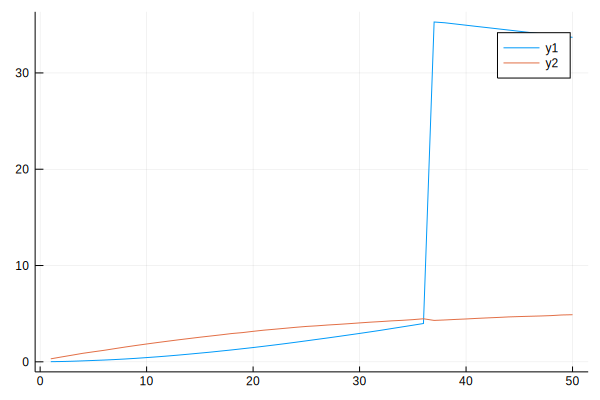

In [258]:
rmse_pos,rmse_vel = rmse_pos_vel(truerec,rec_multimodel,veh_id_list)
plot(rmse_pos)
plot!(rmse_vel)

# Filtering functions

In [ ]:
function compute_particle_vel_likelihoods(roadway,f,truvel,p_set_dict;car_id=-1)
    if car_id==-1 @show "Please give valid car_id" end
    timestep = 0.04 #TODO: Remove hardcoding, 0.04 is for highd
    p_mat, params, vec_val_vec = to_matrix_form(p_set_dict)
    
    num_params=size(p_mat)[1]
    num_p = size(p_mat)[2]
    lkhd_vec = Array{Float64}(undef,num_p)
    for i in 1:num_p    
        # Create dict version for a single particle
        p_dict = Dict()
        for j in 1:num_params
            p_dict[params[j]]=vec_val_vec[j][i]
        end
        
        std_dev_acc = p_dict[:σ]
        
        # hack to avoid the std_dev_pos become negative and error Normal distb
        if std_dev_acc <= 0 std_dev_acc = 0.1 end
        
            # Here is the velocity based calculation
        std_dev_vel = timestep*std_dev_acc
        hvel = hallucinate_vel(roadway,f,p_dict,car_id=car_id)
        lkhd_vec[i] = pdf(Normal(hvel,std_dev_vel),truvel[1])
    end

    return lkhd_vec,p_mat,params
end

In [ ]:
# Test for compute_particle_likelihoods
v_array = [10.,15.,20.,25.,30.]
num_p = length(v_array)
sig_array = [0.1,0.3,0.2,0.4,0.5]	
p_set_dict = Dict(:v_des=>v_array,:σ=>sig_array)
td1 = traj_highd;
scene = Scene(500)
get!(scene,td1,1)
roadway = roadway_highd;
    # trupos is a misnomer here as it is generated by hallucination
    # and is not the real data
trupos = hallucinate_a_step(roadway,scene,Dict(:v_des=>25.0,:σ=>0.0),
    car_id=3)
    
lkhd_vec,p_mat,params = compute_particle_likelihoods(roadway,scene,
    trupos,p_set_dict,car_id=3)
@show lkhd_vec
@test length(lkhd_vec) == num_p
@test length(params) == 2
@test size(p_mat)[1] == 2
@test size(p_mat)[2] == 5
@test any(isnan,lkhd_vec) == false #Gets triggered when wrong car_id called
# For example only 1 car on road but you say car_id = 2

In [ ]:
# Uses velocity instead of position, be careful
function update_p_one_step_vel(roadway,f,truvel,p_set_dict;car_id=-1)
    if car_id==-1 @show "Provide valid car_id" end
    
    lkhd_vec,p_mat,params = compute_particle_vel_likelihoods(roadway,
        f,truvel,p_set_dict,car_id=car_id)
    
    num_params = size(p_mat)[1]
    num_p = size(p_mat)[2]
    
    ll_vec = log.(lkhd_vec)
    
    # TODO: This is hacky. What if log is not negative
    for i in 1:num_p
        if isinf(ll_vec[i])
            ll_vec[i] = 0
        else
            ll_vec[i] = -1*1/ll_vec[i]
        end
    end
    
    p_weight_vec = weights(ll_vec./sum(ll_vec)) # Convert to weights form to use julia sampling
    idx = sample(1:num_p,p_weight_vec,num_p)
    
    new_p_mat = p_mat[:,idx] #Careful that idx is (size,1) and not (size,2)
    
    new_p_set_dict = to_dict_form(params,new_p_mat)
    return new_p_set_dict
end

In [ ]:
# Run filtering and make a plot
# Velocity variant
num_p = 500
p_set_dict = gen_test_particles(num_p)
plots = []
init_p_mat = to_particleMatrix(p_set_dict)

push!(plots,plot_particles(init_p_mat,0.0))
car_id = 6

for framenum in 1:50
    scene = Scene(500)
    get!(scene,traj_highd,framenum+1)
    truvel = scene.entities[findfirst(car_id,scene)].state.v
    
    # Get the scene to start hallucinating from
    scene = Scene(500)
    get!(scene,traj_highd,framenum)
    p_set_new = update_p_one_step(roadway_highd,scene,truvel,p_set_dict,car_id=car_id)
    p_set_dict = p_set_new
    
    set_for_plotting = to_particleMatrix(p_set_new)
    push!(plots,plot_particles(set_for_plotting,framenum*0.04))
end
make_gif(plots,filename = "vel_test_highd_$(car_id).mp4")

# Driving functions

In [ ]:
# Function to return the velocity after hallucination
# Idea is to combine this with position likelihood
function hallucinate_vel(roadway,scene_input,particle;car_id=-1)
    if car_id==-1 @show "Please give valid car_id" end
    
    scene = deepcopy(scene_input)
    #scene = scene_input # This was the failure case
    n_cars = scene.n 

    models = Dict{Int, DriverModel}()
    
    # Create driver models for all the cars in the scene
    for veh in scene
        if veh.id == car_id
            models[veh.id] = IntelligentDriverModel(;particle...)
        else
            # TODO: RESEARCH QUESTION: What drives the other vehicles in the hallucination
            models[veh.id] = IntelligentDriverModel(v_des=10.0)
        end
    end
    
    n_steps = 1
    dt = 0.04
    rec = SceneRecord(n_steps, dt)
    
    simulate!(rec, scene, roadway, models, n_steps)
    
    X = Array{Float64}(undef,n_steps, 1)

    for t in 1:n_steps
        f = rec.frames[n_steps - t + 1]
        
            # Access the vehicle with id as car_id and return its frenet s
        X[t,1] = scene.entities[findfirst(car_id,f)].state.v
    end
    return X[1]
end

In [ ]:
# Test for hallucinate_a_step
timestep = 0.04 # This is the highd timestep
test_num = 5 # The array element number in the scene. Gives vehicle id later
scene = Scene(500)
get!(scene,traj_highd,1)
vehid = scene.entities[test_num].id
@show vehid
vehicle = scene.entities[findfirst(scene.entities[test_num].id,scene)]
print("Location before hallucination = $(vehicle.state.posG.x)\n")
print("Velocity before hallucination = $(vehicle.state.v)\n")
sig_particle = 0.1
particle = Dict(:v_des=>34.0,:σ=>sig_particle)
hall_pos = hallucinate_a_step(roadway_highd,scene,particle,car_id=vehid)
hall_vel = hallucinate_vel(roadway_highd,scene,particle,car_id=vehid)
@show hall_pos,hall_vel
scene = Scene(500)
get!(scene,traj_highd,2)
vehicle = scene.entities[findfirst(vehid,scene)]
trupos = (vehicle.state.posG.x)
truvel = vehicle.state.v
ll_pos = log(pdf(Normal(hall_pos,timestep*timestep*sig_particle),trupos))
ll_vel = log(pdf(Normal(hall_vel,timestep*sig_particle),truvel))

# If log likelihood position is not infinity then we show the position
if isinf(ll_pos)
    if isinf(ll_vel)
        print("Nothing doing\n")
    else
        @show ll_vel
    end
else
    @show ll_pos+ll_vel
end

In [ ]:
# See how 100% sampled results are only one particle
# This is particle deprivation in action
lkhd_vec = zeros(5,1)
@show lkhd_vec
num_p = 5
for i in 1:num_p
    lkhd_vec[i] = pdf(Normal(302.57,0.16*0.16*i*0.2),302.747)
end
@show lkhd_vec
p_weight_vec = weights(lkhd_vec./sum(lkhd_vec))
@show p_weight_vec
idx = sample(1:5,p_weight_vec,5)
@show make this happen

# Code dump for use later/make functions

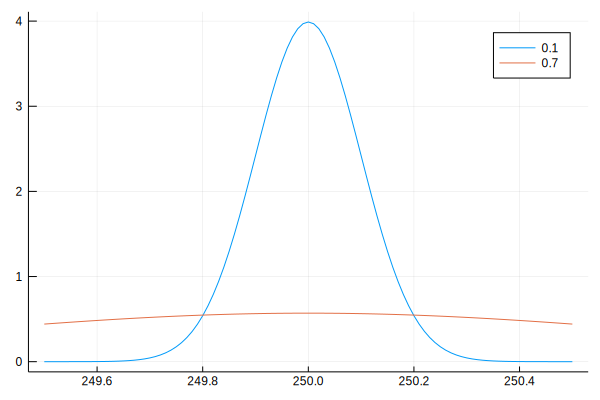

In [65]:
# Plot two gaussians around hallucinated position
# Helps identify how close trupos needs to be to hallucinated position to select which sigma
hpos = 250;sig1=0.1;d1 = Normal(hpos,sig1)
hpos = 250;sig2=0.7;d2 = Normal(hpos,sig2)
plot([i for i in 249.5:0.01:250.5],[pdf(d1,i) for i in 249.5:0.01:250.5],label="$(sig1)")
plot!([i for i in 249.5:0.01:250.5],[pdf(d2,i) for i in 249.5:0.01:250.5],label="$(sig2)")